In [1]:
import rdata
import os
import pandas as pd
import pickle

In [2]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.pyplot as plt 
import matplotlib as mpl


In [3]:
## read in all the Rda data and save them as pickle

# location of the `rda` files of paletteer
file_loc = os.path.join('.', 'r-paletteer', 'paletteer', 'data')

def regenerate_palette_pickle(file_loc):
    files = os.listdir(file_loc)

    all_data = {}

    for f in files:
        parsed = rdata.parser.parse_file(os.path.join(file_loc, f))
        converted = rdata.conversion.convert(parsed)
        keys = list(converted.keys())
        key = keys[0]
        all_data[key] = converted[key]

    with open('all_data.pkl', 'wb') as f:
        pickle.dump(all_data, f)
        
## after a git pull: 
# regenerate_palette_pickle(file_loc=file_loc)

In [4]:
## create pal_data 

all_data = pd.read_pickle(r'all_data.pkl')

pal_names = pd.concat([all_data['palettes_d_names'], all_data['palettes_c_names'], all_data['palettes_dynamic_names']])

pal_dynamic = pd.DataFrame.from_dict(all_data['palettes_dynamic'], orient='index')\
    .stack().to_frame()\
    .reset_index()\
    .rename(columns={0:'color_data', 'level_0': 'package', 'level_1':'palette'})\
    .explode(column='color_data')\
    .assign(color_len=lambda x: x['color_data'].apply(len))\
    .assign(dynamic=True)

pal_discrete = pd.DataFrame.from_dict(all_data['palettes_d'], orient='index')\
    .stack().to_frame()\
    .reset_index()\
    .rename(columns={0:'color_data', 'level_0': 'package', 'level_1':'palette'})\
    .assign(color_len=lambda x: x['color_data'].apply(len))\
    .assign(dynamic=False)

pal_data = pd.concat([pal_dynamic, pal_discrete])

## merge color data with the metadaa about the type
pal_data = pal_data.merge(pal_names[['package', 'palette', 'length', 'type']], 
               on=['package', 'palette'], 
               how='left')

## some metadata are missing - fill in the length 
pal_data['length'] = pal_data['length'].fillna(pal_data['color_data'].apply(len))

## assign palettes with missing type to qualitative 
pal_data['type'] = pal_data['type'].fillna('qualitative')

pal_data = pal_data.rename(columns={'type':'pal_type'})


Fixed-width: fixed amount of colors  `palettes_d_names`  
Dynamic: colors can be generated  `palettes_dynamic_names`  
Continuous: smooth transitions  `palettes_c_names`  

In [5]:
class paletteer_pal: 
    def __init__(self, package, palette, pal_type, color_data, **kw_args): 
        self.package = package
        self.palette = palette 
        self.pal_type = pal_type 
        self.color_data = color_data
        self._cmap_name = '{}::{}'.format(self.package, self.palette)
    
    def get_cmap_segmented(self): 
        cmap = ListedColormap(name=self._cmap_name, 
                              colors = self.color_data)
        return cmap
    
    def get_cmap_continuous(self): 
        cmap = LinearSegmentedColormap.from_list(name=self._cmap_name,
                                                 colors=self.color_data)
        return cmap 
    
    def register_plt(self, which, custom_name=None):
        if which not in ['segmented', 'continuous']: 
            ValueError('pick `segmented` or `continuous`')
        if which == 'segmented': 
            if custom_name is None: 
                custom_name = "{}::{}".format(self._cmap_name, which)
            plt.register_cmap(custom_name, self.get_cmap_segmented())
        else: 
            if custom_name is None: 
                custom_name = "{}::{}".format(self._cmap_name, which)
            plt.register_cmap(custom_name, self.get_cmap_continuous())

In [6]:
def show_random_map(random_state=None):
    return paletteer_pal(**pal_data\
                      .sample(1, random_state=random_state)\
                      .iloc[0].to_dict())\
                .get_cmap_segmented()

In [7]:
def create_pal_object(package, palette, N=None):
    if package not in pal_data['package'].unique(): 
        ValueError('package not found')
    if palette not in pal_data['palette'].unique(): 
        ValueError('palette name not found')
    
    sel_pal = pal_data[(pal_data['package']==package) & (pal_data['palette']==palette)]
    
    max_len = sel_pal['color_len'].max()
    if ((N is None) or (N not in sel_pal['color_len'].unique())): 
        print('incorrect N; setting N colors to max available value: {}'.format(max_len))
        N = max_len
        
    chosen = sel_pal[sel_pal['color_len']==N]
    out = paletteer_pal(**chosen.iloc[0].to_dict())
    return out 

In [8]:
def list_palettes(pal_type=None):
    pal_types_uq = pal_data['pal_type'].unique()
    if pal_type not in pal_types_uq: 
        ValueError('available palette types: ', pal_types_uq)
        
    if pal_type is None: 
        out = pal_data[['package', 'palette']].drop_duplicates()\
            .apply(lambda x: '{}::{}'.format(x['package'], x['palette']), axis=1)
    else: 
        out = pal_data[pal_data['pal_type']==pal_type][['package', 'palette']].drop_duplicates()\
            .apply(lambda x: '{}::{}'.format(x['package'], x['palette']), axis=1)
        
    return out.values.tolist()

In [9]:
def print_user_registered_cmaps():
    return [cm  for cm in plt.colormaps() if cm not in dir(plt.cm)]

___

In [10]:
list_palettes('sequential')[:20]

['cartography::blue.pal',
 'cartography::orange.pal',
 'cartography::red.pal',
 'cartography::brown.pal',
 'cartography::green.pal',
 'cartography::purple.pal',
 'cartography::pink.pal',
 'cartography::wine.pal',
 'cartography::grey.pal',
 'cartography::turquoise.pal',
 'cartography::sand.pal',
 'cartography::taupe.pal',
 'cartography::kaki.pal',
 'cartography::harmo.pal',
 'awtools::a_palette',
 'awtools::gpalette',
 'khroma::devon',
 'khroma::lajolla',
 'khroma::bamako',
 'khroma::davos']

In [11]:
pal2 = create_pal_object(package='beyonce', palette='X2', N=3)

incorrect N; setting N colors to max available value: 6


In [12]:
pal2.color_data

['#0F2B5F', '#5991C7', '#8EC1E7', '#B9DBF1', '#D5A370', '#7B4F37']

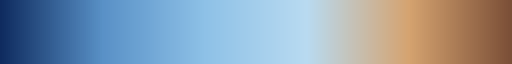

In [13]:
pal2.get_cmap_continuous()

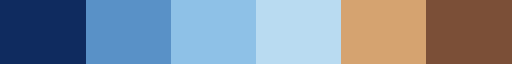

In [14]:
pal2.get_cmap_segmented()

In [15]:
pal2.register_plt(which='segmented')

In [16]:
print_user_registered_cmaps()

['beyonce::X2::segmented']

In [17]:
## to unregister: 
# mpl.colormaps.unregister('beyonce::X2::segmented')

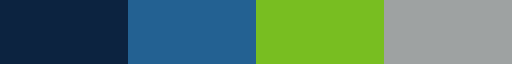

In [18]:
show_random_map()